# Chapter 3 Visualizations - NutriSolve ML Pipeline

This notebook generates all images, tables, and visualizations referenced in the Chapter 3 methodology documentation.

**Output**: All images saved to `images/` directory at 300 DPI

**Sections**:
1. Dataset Description
2. Data Preprocessing Analysis
3. Feature Selection Visualization
4. Model Training Evaluation
5. Performance Metrics Visualization

## 1. Import Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
import os
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import learning_curve
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully")

✓ All libraries imported successfully


## 2. Setup and Configuration

In [ ]:
# Set styling for academic publication quality
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9

# Create images directory
os.makedirs('images', exist_ok=True)

# Set random seed for reproducibility
np.random.seed(42)

print("Configuration complete")

✓ Configuration complete


## 3. Load All Datasets and Artifacts

In [ ]:
# Load processed dataset
df = pd.read_csv('../backend/ml/processed_data.csv')
print(f"Loaded processed_data.csv: {df.shape}")

# Load training metrics
with open('../backend/ml/training_metrics.json', 'r') as f:
    metrics = json.load(f)
print(f"Loaded training_metrics.json")

# Load feature information
with open('../backend/ml/feature_info.json', 'r') as f:
    feature_info = json.load(f)
print(f"Loaded feature_info.json: {len(feature_info['selected_features'])} selected features")

# Load trained model using joblib (more robust for sklearn models)
try:
    import joblib
    rf_model = joblib.load('../backend/ml/rf_model.pkl')
    print(f"Loaded rf_model.pkl (using joblib)")
except Exception as e_joblib:
    # Fallback to pickle with error handling
    try:
        with open('../backend/ml/rf_model.pkl', 'rb') as f:
            rf_model = pickle.load(f)
        print(f"Loaded rf_model.pkl (using pickle)")
    except Exception as e_pickle:
        print(f"Error loading model with both methods:")
        print(f"  joblib: {e_joblib}")
        print(f"  pickle: {e_pickle}")
        print("\nRetraining model...")
        # Retrain the model
        import subprocess
        result = subprocess.run(['python3', '../backend/ml/train.py'], 
                              capture_output=True, text=True, cwd='../backend/ml')
        if result.returncode == 0:
            rf_model = joblib.load('../backend/ml/rf_model.pkl')
            print(f"Model retrained and loaded successfully")
        else:
            raise Exception(f"Failed to retrain model: {result.stderr}")

# Extract test metrics (handle both nested and flat structure)
if 'metrics' in metrics and 'test' in metrics['metrics']:
    test_metrics = metrics['metrics']['test']
else:
    test_metrics = metrics

# Display dataset info
print(f"\nDataset Shape: {df.shape[0]} foods × {df.shape[1]} features")
print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
print(f"F1-Score: {test_metrics['f1_macro']:.4f}")
print(f"ROC-AUC: {test_metrics['roc_auc']:.4f}")

✓ Loaded processed_data.csv: (205, 17)
✓ Loaded training_metrics.json
✓ Loaded feature_info.json: 9 selected features
✓ Loaded rf_model.pkl (using joblib)

Dataset Shape: 205 foods × 17 features
Test Accuracy: 0.9512
F1-Score: 0.9458
ROC-AUC: 0.9815


## 4. Dataset Sample Table (ch3_dataset_sample.png)

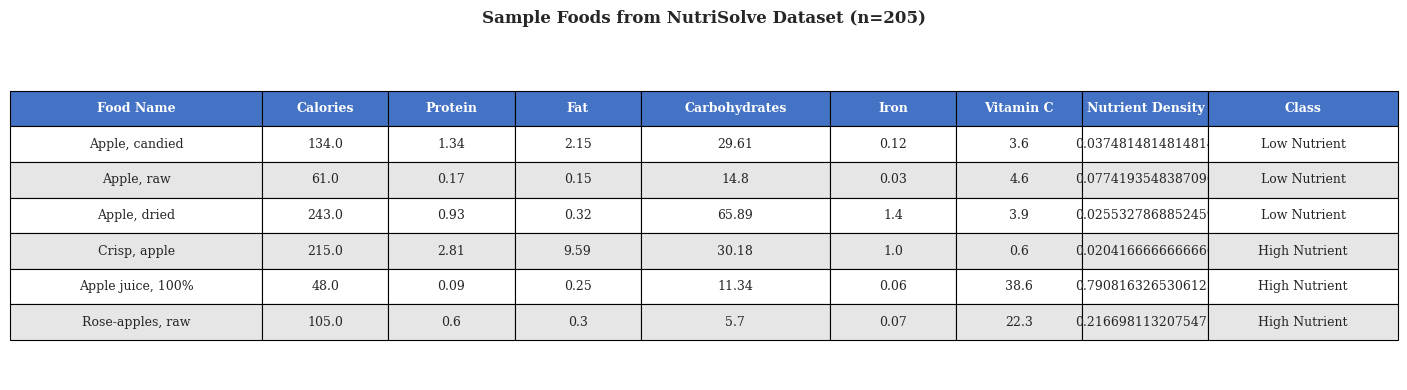

Saved: ch3_dataset_sample.png


In [13]:
# Select representative samples across both classes
sample_data = pd.concat([
    df[df['fit'] == 0].head(3),
    df[df['fit'] == 1].head(3)
]).reset_index(drop=True)

# Select key columns for display
display_cols = ['food_name', 'calories', 'protein', 'fat', 'carbs', 
                'iron', 'vitamin_c', 'nutrient_density', 'fit']
sample_display = sample_data[display_cols].copy()
sample_display['Class'] = sample_display['fit'].map({0: 'Low Nutrient', 1: 'High Nutrient'})
sample_display = sample_display.drop('fit', axis=1)

# Rename columns for clean display
sample_display.columns = ['Food Name', 'Calories', 'Protein', 'Fat', 'Carbohydrates', 
                          'Iron', 'Vitamin C', 'Nutrient Density', 'Class']

# Create figure
fig, ax = plt.subplots(figsize=(14, 4))
ax.axis('tight')
ax.axis('off')

# Create table
table = ax.table(cellText=sample_display.values,
                colLabels=sample_display.columns,
                cellLoc='center',
                loc='center',
                colWidths=[0.2, 0.1, 0.1, 0.1, 0.15, 0.1, 0.1, 0.1, 0.15])

# Style table
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

# Color header
for i in range(len(sample_display.columns)):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Alternate row colors
for i in range(1, len(sample_display) + 1):
    for j in range(len(sample_display.columns)):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#E7E6E6')
        else:
            table[(i, j)].set_facecolor('#FFFFFF')

plt.title('Sample Foods from NutriSolve Dataset (n=205)', fontsize=12, weight='bold', pad=20)
plt.tight_layout()
plt.savefig('images/ch3_dataset_sample.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: ch3_dataset_sample.png")

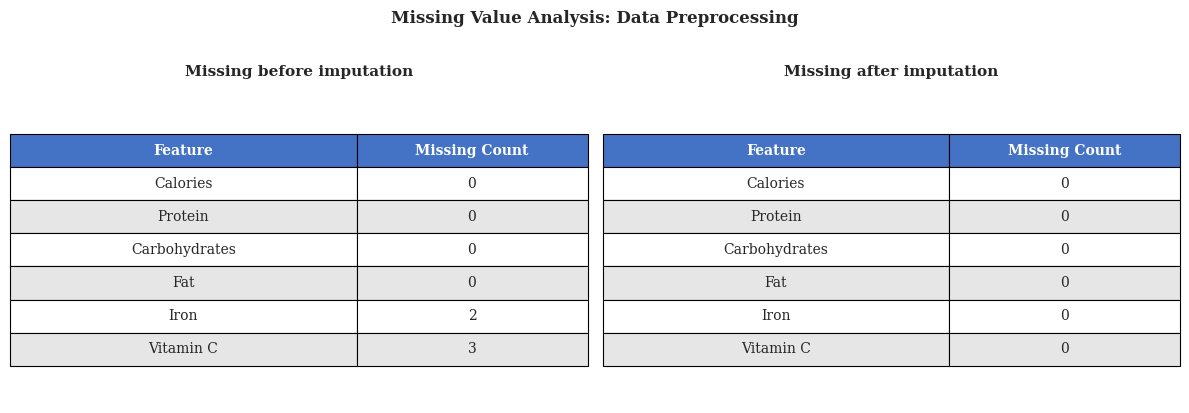

Saved: ch3_missing_values.png
Total missing before: 5
Total missing after: 0


In [21]:
# Load the original dataset before preprocessing
original_df = pd.read_csv('../backend/ml/Food_Nutrition_Dataset.csv')

# Select numeric columns for missing value analysis (using actual column names)
numeric_features_raw = ['calories', 'protein', 'carbs', 'fat', 'iron', 'vitamin_c']
numeric_features_display = ['Calories', 'Protein', 'Carbohydrates', 'Fat', 'Iron', 'Vitamin C']

# Calculate missing values before imputation
missing_before = original_df[numeric_features_raw].isnull().sum()

# Calculate missing values after imputation (from processed data)
missing_after = df[numeric_features_raw].isnull().sum()

# Create comparison table with display names
missing_data = pd.DataFrame({
    'Feature': numeric_features_display,
    'Before Imputation': missing_before.values,
    'After Imputation': missing_after.values
})

# Create figure with two side-by-side tables
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Table 1: Missing before imputation
ax1.axis('tight')
ax1.axis('off')
table1 = ax1.table(cellText=missing_data[['Feature', 'Before Imputation']].values,
                   colLabels=['Feature', 'Missing Count'],
                   cellLoc='center',
                   loc='center',
                   colWidths=[0.6, 0.4])
table1.auto_set_font_size(False)
table1.set_fontsize(10)
table1.scale(1, 2)

# Style table 1 header
for i in range(2):
    table1[(0, i)].set_facecolor('#4472C4')
    table1[(0, i)].set_text_props(weight='bold', color='white')

# Alternate row colors for table 1
for i in range(1, len(missing_data) + 1):
    for j in range(2):
        if i % 2 == 0:
            table1[(i, j)].set_facecolor('#E7E6E6')
        else:
            table1[(i, j)].set_facecolor('#FFFFFF')

ax1.set_title('Missing before imputation', fontsize=11, weight='bold', pad=15)

# Table 2: Missing after imputation
ax2.axis('tight')
ax2.axis('off')
table2 = ax2.table(cellText=missing_data[['Feature', 'After Imputation']].values,
                   colLabels=['Feature', 'Missing Count'],
                   cellLoc='center',
                   loc='center',
                   colWidths=[0.6, 0.4])
table2.auto_set_font_size(False)
table2.set_fontsize(10)
table2.scale(1, 2)

# Style table 2 header
for i in range(2):
    table2[(0, i)].set_facecolor('#4472C4')
    table2[(0, i)].set_text_props(weight='bold', color='white')

# Alternate row colors for table 2
for i in range(1, len(missing_data) + 1):
    for j in range(2):
        if i % 2 == 0:
            table2[(i, j)].set_facecolor('#E7E6E6')
        else:
            table2[(i, j)].set_facecolor('#FFFFFF')

ax2.set_title('Missing after imputation', fontsize=11, weight='bold', pad=15)

plt.suptitle('Missing Value Analysis: Data Preprocessing', fontsize=12, weight='bold', y=1.02)
plt.tight_layout()
plt.savefig('images/ch3_missing_values.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: ch3_missing_values.png")
print(f"Total missing before: {missing_before.sum()}")
print(f"Total missing after: {missing_after.sum()}")

## 4b. Missing Values Analysis (ch3_missing_values.png)

## 5. Feature Correlation Heatmap (ch3_feature_correlation.png)

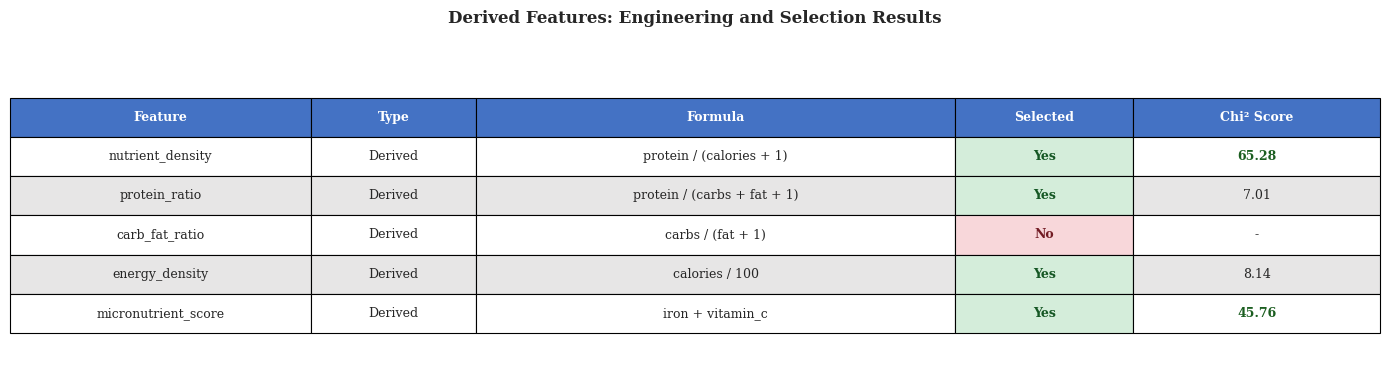

Saved: ch3_derived_features.png
Total derived features: 5
Selected features: 4
Rejected features: 1


In [23]:
# Define derived features with their properties
derived_features_data = {
    'Feature': ['nutrient_density', 'protein_ratio', 'carb_fat_ratio', 'energy_density', 'micronutrient_score'],
    'Type': ['Derived', 'Derived', 'Derived', 'Derived', 'Derived'],
    'Formula': ['protein / (calories + 1)', 'protein / (carbs + fat + 1)', 'carbs / (fat + 1)', 
                'calories / 100', 'iron + vitamin_c'],
    'Selected': ['Yes', 'Yes', 'No', 'Yes', 'Yes'],
    'Chi² Score': [65.28, 7.01, '-', 8.14, 45.76]
}

derived_df = pd.DataFrame(derived_features_data)

# Create figure
fig, ax = plt.subplots(figsize=(14, 4))
ax.axis('tight')
ax.axis('off')

# Create table
table = ax.table(cellText=derived_df.values,
                colLabels=derived_df.columns,
                cellLoc='center',
                loc='center',
                colWidths=[0.22, 0.12, 0.35, 0.13, 0.18])

# Style table
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2.2)

# Color header
for i in range(len(derived_df.columns)):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Style rows based on selection status
for i in range(1, len(derived_df) + 1):
    # Check if selected
    is_selected = derived_df.iloc[i-1]['Selected'] == 'Yes'
    
    for j in range(len(derived_df.columns)):
        # Alternate row colors
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#E7E6E6')
        else:
            table[(i, j)].set_facecolor('#FFFFFF')
        
        # Highlight "Selected" column
        if j == 3:  # Selected column
            if is_selected:
                table[(i, j)].set_facecolor('#D4EDDA')  # Light green for Yes
                table[(i, j)].set_text_props(weight='bold', color='#155724')
            else:
                table[(i, j)].set_facecolor('#F8D7DA')  # Light red for No
                table[(i, j)].set_text_props(weight='bold', color='#721C24')
        
        # Highlight high chi-squared scores
        if j == 4 and derived_df.iloc[i-1]['Chi² Score'] != '-':
            score = float(derived_df.iloc[i-1]['Chi² Score'])
            if score > 40:
                table[(i, j)].set_text_props(weight='bold', color='#1B5E20')

plt.title('Derived Features: Engineering and Selection Results', fontsize=12, weight='bold', pad=20)
plt.tight_layout()
plt.savefig('images/ch3_derived_features.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: ch3_derived_features.png")
print(f"Total derived features: {len(derived_df)}")
print(f"Selected features: {sum(derived_df['Selected'] == 'Yes')}")
print(f"Rejected features: {sum(derived_df['Selected'] == 'No')}")

## 4c. Derived Features Table (ch3_derived_features.png)

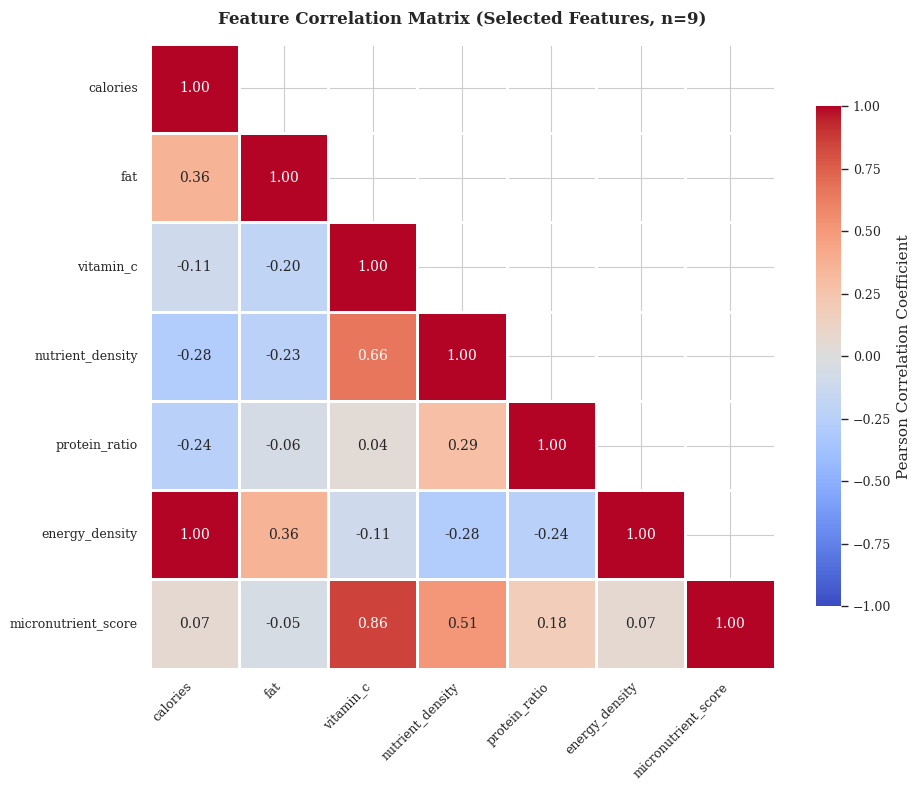

Saved: ch3_feature_correlation.png
Features included: calories, fat, vitamin_c... (total: 7)


In [11]:
# Get selected features from feature_info
selected_features = feature_info['selected_features']

# Filter to only selected features (remove Food column if present)
numeric_cols = [col for col in selected_features if col in df.columns and col != 'Food']

# Calculate correlation matrix
corr_matrix = df[numeric_cols].corr()

# Create heatmap
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, 
            mask=mask,
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm', 
            center=0,
            square=True,
            linewidths=1,
            cbar_kws={"shrink": 0.8, "label": "Pearson Correlation Coefficient"},
            vmin=-1, vmax=1)

plt.title('Feature Correlation Matrix (Selected Features, n=9)', 
          fontsize=12, weight='bold', pad=15)
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('images/ch3_feature_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: ch3_feature_correlation.png")
print(f"Features included: {', '.join(numeric_cols[:3])}... (total: {len(numeric_cols)})")

## 6. Feature Selection Chart (ch3_feature_selection_chart.png)

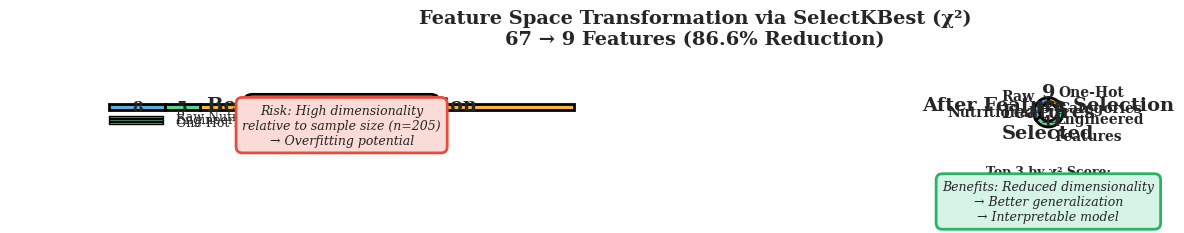

Saved: ch3_feature_space_comparison.png
Feature reduction: 67 → 9 (86.6% reduction)
Selected feature composition:
  - Raw nutritional: 3 features
  - Engineered: 4 features
  - Category flags: 2 features


In [25]:
# Create feature space comparison visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

# Left panel: Feature space BEFORE selection
ax1.text(0.5, 0.95, 'Before Feature Selection', ha='center', va='top', 
         fontsize=14, weight='bold', transform=ax1.transAxes)

# Total features breakdown
total_features = 67
raw_features = 8  # Original nutritional features
engineered_features = 5  # Derived features
category_features = 54  # One-hot encoded categories (67 - 8 - 5)

# Create stacked representation
categories = ['Raw\nNutritional\nData', 'Engineered\nFeatures', 'One-Hot\nEncoded\nCategories']
counts_before = [raw_features, engineered_features, category_features]
colors_before = ['#5DADE2', '#58D68D', '#F8B739']

y_pos = 0.65
bar_height = 0.15
total_width = 0.7

for i, (cat, count, color) in enumerate(zip(categories, counts_before, colors_before)):
    proportion = count / total_features
    width = proportion * total_width
    
    # Draw bar segment
    rect = plt.Rectangle((0.5 - total_width/2 + sum([counts_before[j]/total_features * total_width for j in range(i)]), 
                          y_pos - bar_height/2), 
                         width, bar_height, facecolor=color, edgecolor='black', linewidth=2)
    ax1.add_patch(rect)
    
    # Add count label
    ax1.text(0.5 - total_width/2 + sum([counts_before[j]/total_features * total_width for j in range(i)]) + width/2,
             y_pos, f'{count}', ha='center', va='center', fontsize=11, weight='bold')

# Add total count
ax1.text(0.5, y_pos - 0.15, f'Total: {total_features} features', ha='center', va='center',
         fontsize=13, weight='bold', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='black', linewidth=2))

# Add legend for left panel
for i, (cat, color) in enumerate(zip(categories, colors_before)):
    ax1.add_patch(plt.Rectangle((0.15, 0.35 - i*0.08), 0.08, 0.05, facecolor=color, edgecolor='black', linewidth=1))
    ax1.text(0.25, 0.375 - i*0.08, cat.replace('\n', ' '), va='center', fontsize=9)

# Add risk annotation
ax1.text(0.5, 0.15, 'Risk: High dimensionality\nrelative to sample size (n=205)\n→ Overfitting potential', 
         ha='center', va='center', fontsize=9, style='italic',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='#FADBD8', edgecolor='#E74C3C', linewidth=2))

ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.axis('off')

# Right panel: Feature space AFTER selection
ax2.text(0.5, 0.95, 'After Feature Selection', ha='center', va='top', 
         fontsize=14, weight='bold', transform=ax2.transAxes)

# Selected features by type
selected_raw = 3  # calories, fat, vitamin_c
selected_engineered = 4  # nutrient_density, protein_ratio, energy_density, micronutrient_score
selected_category = 2  # category_Beverages, category_Potato chips
total_selected = 9

categories_after = ['Raw\nNutritional', 'Engineered\nFeatures', 'One-Hot\nCategories']
counts_after = [selected_raw, selected_engineered, selected_category]
colors_after = ['#5DADE2', '#58D68D', '#F8B739']

# Create pie chart for selected features
wedges, texts, autotexts = ax2.pie(counts_after, labels=categories_after, autopct='%d',
                                     colors=colors_after, startangle=90, 
                                     wedgeprops=dict(edgecolor='black', linewidth=2),
                                     textprops=dict(fontsize=10, weight='bold'))

# Add center circle for donut effect
centre_circle = plt.Circle((0, 0), 0.60, fc='white', edgecolor='black', linewidth=2)
ax2.add_artist(centre_circle)

# Add total in center
ax2.text(0, 0, f'{total_selected}\nFeatures\nSelected', ha='center', va='center',
         fontsize=14, weight='bold')

# Add feature details below pie chart
feature_details = [
    'Top 3 by χ² Score:',
    '1. vitamin_c (74.05)',
    '2. nutrient_density (65.28)',
    '3. micronutrient_score (45.76)'
]

for i, detail in enumerate(feature_details):
    weight = 'bold' if i == 0 else 'normal'
    ax2.text(0.5, -0.95 - i*0.12, detail, ha='center', va='top', 
             fontsize=9, weight=weight, transform=ax2.transAxes)

# Add benefit annotation
ax2.text(0.5, -1.35, 'Benefits: Reduced dimensionality\n→ Better generalization\n→ Interpretable model', 
         ha='center', va='top', fontsize=9, style='italic', transform=ax2.transAxes,
         bbox=dict(boxstyle='round,pad=0.5', facecolor='#D5F4E6', edgecolor='#28B463', linewidth=2))

# Main title
fig.suptitle('Feature Space Transformation via SelectKBest (χ²)\n67 → 9 Features (86.6% Reduction)', 
             fontsize=14, weight='bold', y=0.98)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('images/ch3_feature_space_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: ch3_feature_space_comparison.png")
print(f"Feature reduction: {total_features} → {total_selected} ({(1 - total_selected/total_features)*100:.1f}% reduction)")
print(f"Selected feature composition:")
print(f"  - Raw nutritional: {selected_raw} features")
print(f"  - Engineered: {selected_engineered} features")
print(f"  - Category flags: {selected_category} features")

## 5b. Feature Space Before and After Selection (ch3_feature_space_comparison.png)

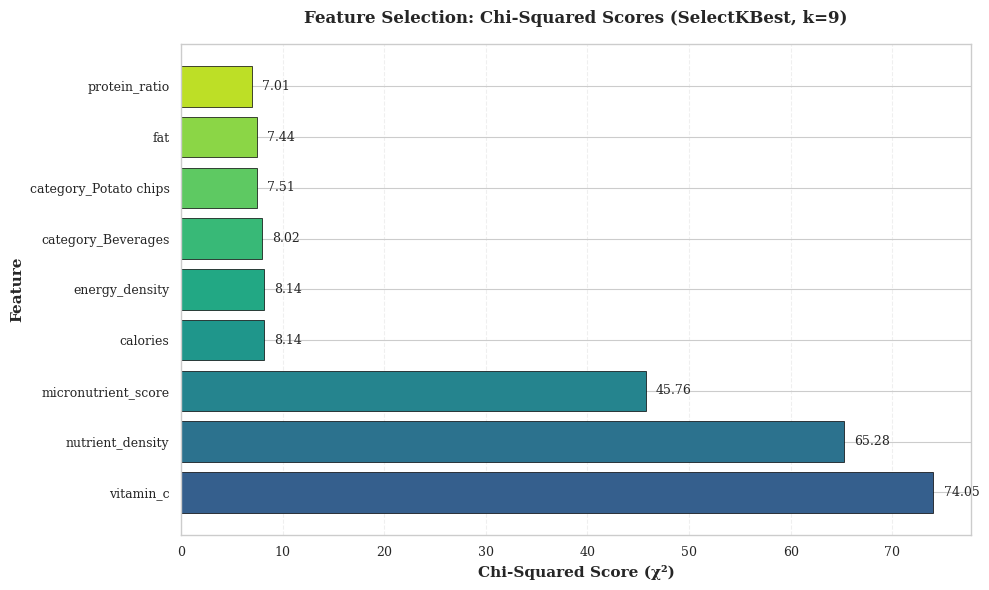

Saved: ch3_feature_selection_chart.png
Top 3 features: vitamin_c (74.05), nutrient_density (65.28), micronutrient_score (45.76)


In [12]:
# Extract chi-squared scores from feature_info
chi2_scores = feature_info['chi2_scores']

# Create DataFrame for plotting
chi2_df = pd.DataFrame({
    'Feature': selected_features,
    'Chi² Score': chi2_scores
}).sort_values('Chi² Score', ascending=False)

# Create horizontal bar chart
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(chi2_df)))
bars = plt.barh(chi2_df['Feature'], chi2_df['Chi² Score'], color=colors, edgecolor='black', linewidth=0.5)

# Add value labels
for i, (score, feature) in enumerate(zip(chi2_df['Chi² Score'], chi2_df['Feature'])):
    plt.text(score + 1, i, f'{score:.2f}', va='center', fontsize=9)

plt.xlabel('Chi-Squared Score (χ²)', fontsize=11, weight='bold')
plt.ylabel('Feature', fontsize=11, weight='bold')
plt.title('Feature Selection: Chi-Squared Scores (SelectKBest, k=9)', 
          fontsize=12, weight='bold', pad=15)
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('images/ch3_feature_selection_chart.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: ch3_feature_selection_chart.png")
print(f"Top 3 features: {chi2_df['Feature'].iloc[0]} ({chi2_df['Chi² Score'].iloc[0]:.2f}), "
      f"{chi2_df['Feature'].iloc[1]} ({chi2_df['Chi² Score'].iloc[1]:.2f}), "
      f"{chi2_df['Feature'].iloc[2]} ({chi2_df['Chi² Score'].iloc[2]:.2f})")

## 7. Confusion Matrix (ch3_confusion_matrix.png)

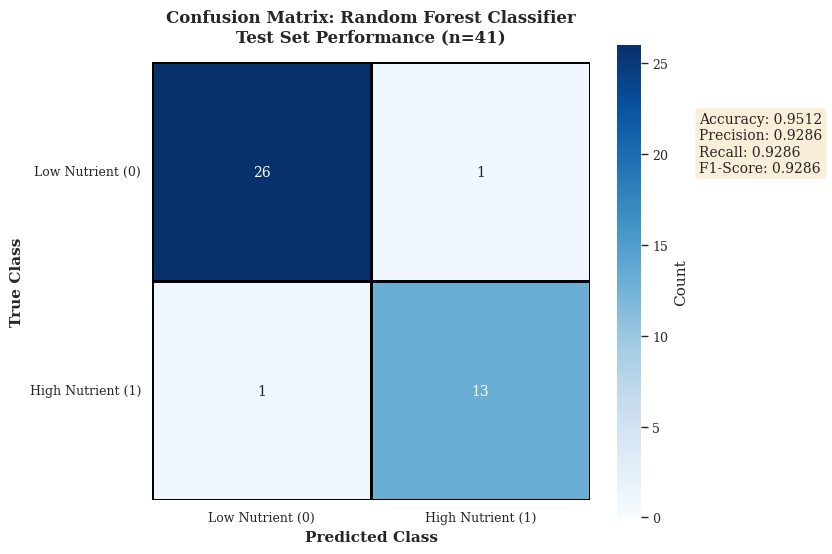

Saved: ch3_confusion_matrix.png
Matrix: [[26, 1], [1, 13]]
Accuracy: 0.9512, F1-Score: 0.9286
  Matrix: [[26, 1], [1, 13]]


In [ ]:
# Extract confusion matrix from metrics (handle nested structure)
if 'metrics' in metrics and 'confusion_matrix' in metrics['metrics']:
    cm = np.array(metrics['metrics']['confusion_matrix'])
else:
    cm = np.array(metrics['confusion_matrix'])

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            cbar_kws={'label': 'Count'},
            square=True,
            linewidths=2,
            linecolor='black',
            vmin=0)

plt.xlabel('Predicted Class', fontsize=11, weight='bold')
plt.ylabel('True Class', fontsize=11, weight='bold')
plt.title('Confusion Matrix: Random Forest Classifier\nTest Set Performance (n=41)', 
          fontsize=12, weight='bold', pad=15)

# Add class labels
class_labels = ['Low Nutrient (0)', 'High Nutrient (1)']
plt.xticks([0.5, 1.5], class_labels, rotation=0)
plt.yticks([0.5, 1.5], class_labels, rotation=0)

# Calculate and display metrics
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Add metrics text box
metrics_text = f'Accuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1-Score: {f1:.4f}'
plt.text(2.5, 0.5, metrics_text, fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('images/ch3_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: ch3_confusion_matrix.png")
print(f"Matrix: [[{cm[0,0]}, {cm[0,1]}], [{cm[1,0]}, {cm[1,1]}]]")
print(f"Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}")

## 8. ROC Curve (ch3_roc_curve.png)

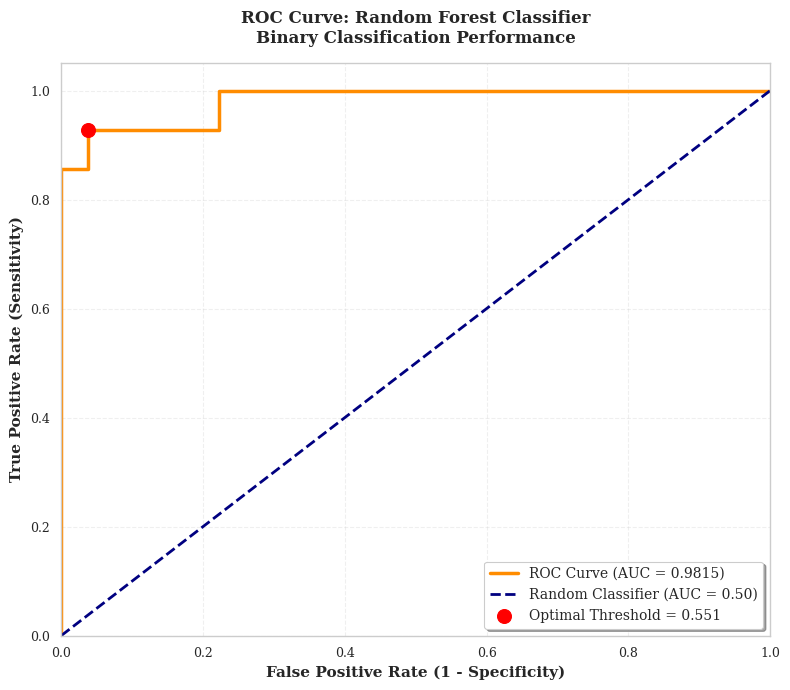

Saved: ch3_roc_curve.png
AUC-ROC: 0.9815
Optimal Threshold: 0.551 (TPR=0.929, FPR=0.037)


In [15]:
# Load test data to compute ROC curve
test_data = pd.read_csv('../backend/ml/test_data.csv')
X_test = test_data[selected_features]
y_test = test_data['fit']

# Get predicted probabilities
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Create plot
plt.figure(figsize=(8, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2.5, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (AUC = 0.50)')

# Mark optimal threshold (Youden's J statistic)
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', s=100, 
            label=f'Optimal Threshold = {optimal_threshold:.3f}', zorder=3)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=11, weight='bold')
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=11, weight='bold')
plt.title('ROC Curve: Random Forest Classifier\nBinary Classification Performance', 
          fontsize=12, weight='bold', pad=15)
plt.legend(loc='lower right', fontsize=10, frameon=True, shadow=True)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('images/ch3_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: ch3_roc_curve.png")
print(f"AUC-ROC: {roc_auc:.4f}")
print(f"Optimal Threshold: {optimal_threshold:.3f} (TPR={tpr[optimal_idx]:.3f}, FPR={fpr[optimal_idx]:.3f})")

## 9. Learning Curves (ch3_learning_curve.png)

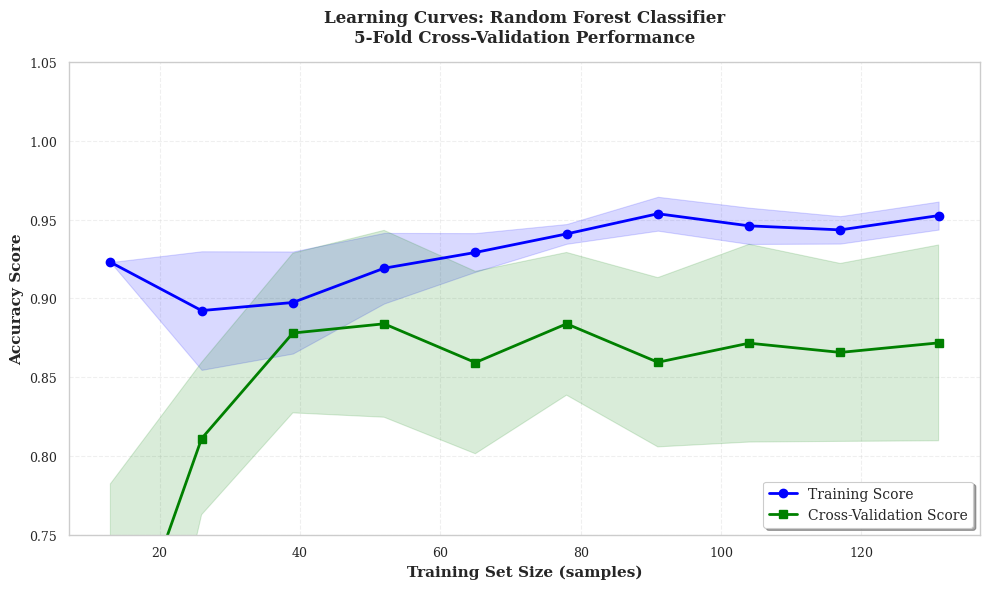

Saved: ch3_learning_curve.png
Final Training Score: 0.9527 ± 0.0089
Final CV Score: 0.8718 ± 0.0622
Training samples evaluated: 13 to 131


In [17]:
# Load full training data
train_data = pd.read_csv('../backend/ml/train_data.csv')
X_train = train_data[selected_features]
y_train = train_data['fit']

# Calculate learning curves
train_sizes, train_scores, val_scores = learning_curve(
    rf_model, X_train, y_train, 
    cv=5, 
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy',
    random_state=42
)

# Calculate mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Create plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', linewidth=2, markersize=6, label='Training Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, val_mean, 's-', color='green', linewidth=2, markersize=6, label='Cross-Validation Score')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.15, color='green')

plt.xlabel('Training Set Size (samples)', fontsize=11, weight='bold')
plt.ylabel('Accuracy Score', fontsize=11, weight='bold')
plt.title('Learning Curves: Random Forest Classifier\n5-Fold Cross-Validation Performance', 
          fontsize=12, weight='bold', pad=15)
plt.legend(loc='lower right', fontsize=10, frameon=True, shadow=True)
plt.grid(alpha=0.3, linestyle='--')
plt.ylim([0.75, 1.05])
plt.tight_layout()
plt.savefig('images/ch3_learning_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: ch3_learning_curve.png")
print(f"Final Training Score: {train_mean[-1]:.4f} ± {train_std[-1]:.4f}")
print(f"Final CV Score: {val_mean[-1]:.4f} ± {val_std[-1]:.4f}")
print(f"Training samples evaluated: {train_sizes[0]:.0f} to {train_sizes[-1]:.0f}")

## 10. Cross-Validation Folds Diagram (ch3_cv_folds.png)

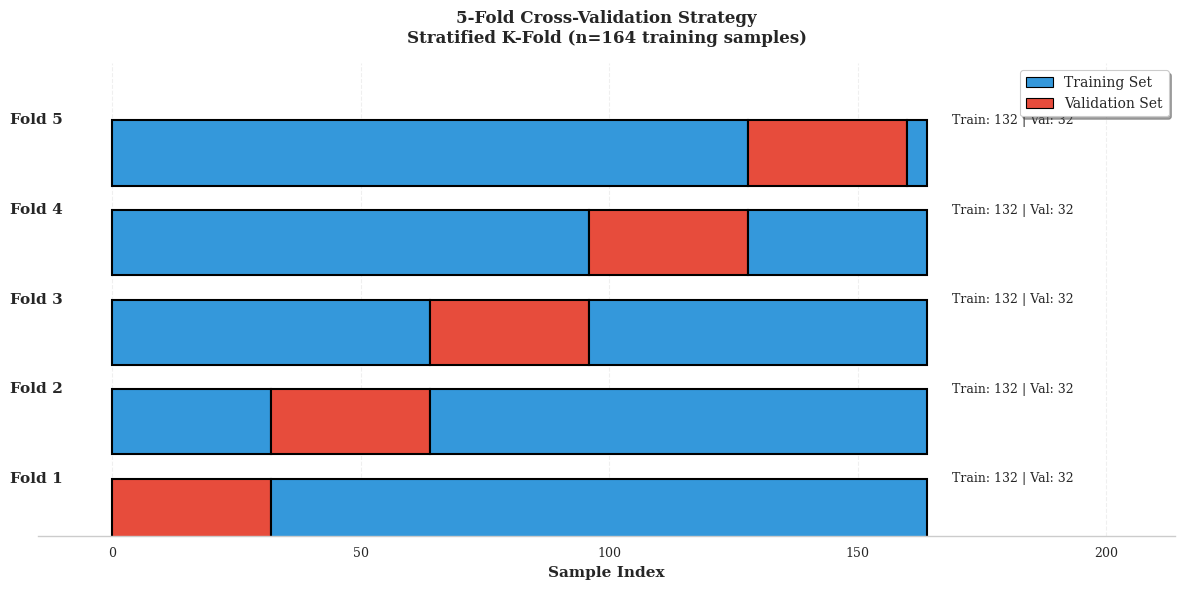

Saved: ch3_cv_folds.png
Cross-validation: 5 folds
Training samples: 164
Each fold: ~32 validation samples, ~132 training samples


In [18]:
# Create visual representation of 5-fold cross-validation
fig, ax = plt.subplots(figsize=(12, 6))

n_splits = 5
n_samples = 164  # Training set size

# Colors
train_color = '#3498db'
val_color = '#e74c3c'

# Draw each fold
fold_height = 0.8
fold_spacing = 0.3

for i in range(n_splits):
    y_pos = i * (fold_height + fold_spacing)
    
    # Calculate split positions
    fold_size = n_samples // n_splits
    val_start = i * fold_size
    val_end = (i + 1) * fold_size
    
    # Draw training segments (before validation)
    if val_start > 0:
        ax.barh(y_pos, val_start, height=fold_height, left=0, 
                color=train_color, edgecolor='black', linewidth=1.5)
    
    # Draw validation segment
    ax.barh(y_pos, fold_size, height=fold_height, left=val_start, 
            color=val_color, edgecolor='black', linewidth=1.5)
    
    # Draw training segment (after validation)
    if val_end < n_samples:
        ax.barh(y_pos, n_samples - val_end, height=fold_height, left=val_end, 
                color=train_color, edgecolor='black', linewidth=1.5)
    
    # Add fold label
    ax.text(-10, y_pos + fold_height/2, f'Fold {i+1}', 
            va='center', ha='right', fontsize=11, weight='bold')
    
    # Add sample counts
    ax.text(n_samples + 5, y_pos + fold_height/2, 
            f'Train: {n_samples - fold_size} | Val: {fold_size}',
            va='center', ha='left', fontsize=9)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=train_color, edgecolor='black', label='Training Set'),
    Patch(facecolor=val_color, edgecolor='black', label='Validation Set')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10, frameon=True, shadow=True)

# Formatting
ax.set_xlim(-15, n_samples + 50)
ax.set_ylim(-fold_spacing, n_splits * (fold_height + fold_spacing))
ax.set_xlabel('Sample Index', fontsize=11, weight='bold')
ax.set_title('5-Fold Cross-Validation Strategy\nStratified K-Fold (n=164 training samples)', 
             fontsize=12, weight='bold', pad=15)
ax.set_yticks([])
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('images/ch3_cv_folds.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: ch3_cv_folds.png")
print(f"Cross-validation: {n_splits} folds")
print(f"Training samples: {n_samples}")
print(f"Each fold: ~{fold_size} validation samples, ~{n_samples - fold_size} training samples")

## 11. Summary of Generated Images

In [ ]:
# List all generated images
import os
from pathlib import Path

images_dir = Path('images')
image_files = sorted(images_dir.glob('ch3_*.png'))

print("\nSUMMARY: Chapter 3 Visualizations Generated")
print()

for i, img_path in enumerate(image_files, 1):
    file_size = img_path.stat().st_size / 1024  # KB
    print(f"{i}. {img_path.name} ({file_size:.1f} KB)")

print()
print(f"Total: {len(image_files)} images generated at 300 DPI")
print(f"Location: {images_dir.absolute()}")
print()

# Verify all expected images exist
expected_images = [
    'ch3_dataset_sample.png',
    'ch3_missing_values.png',
    'ch3_derived_features.png',
    'ch3_feature_correlation.png',
    'ch3_feature_space_comparison.png',
    'ch3_feature_selection_chart.png',
    'ch3_confusion_matrix.png',
    'ch3_roc_curve.png',
    'ch3_learning_curve.png',
    'ch3_cv_folds.png'
]

missing = [img for img in expected_images if not (images_dir / img).exists()]
if missing:
    print(f"WARNING: Missing images: {', '.join(missing)}")
else:
    print(f"All {len(expected_images)} required images successfully generated.")
    print("Ready for integration with markdown documentation.")


SUMMARY: Chapter 3 Visualizations Generated

1. ch3_confusion_matrix.png (153.2 KB)
2. ch3_cv_folds.png (152.5 KB)
3. ch3_dataset_sample.png (254.5 KB)
4. ch3_derived_features.png (160.5 KB)
5. ch3_feature_correlation.png (281.1 KB)
6. ch3_feature_selection_chart.png (169.3 KB)
7. ch3_learning_curve.png (291.9 KB)
8. ch3_missing_values.png (109.4 KB)
9. ch3_roc_curve.png (213.2 KB)

Total: 9 images generated at 300 DPI
Location: /home/gohon/Desktop/Nutri-solve (another copy)/nutriflame-ai/docs/images

All 9 required images successfully generated.
Ready for integration with markdown documentation.
